In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Модель LGBM

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import shap

import os
import src

from dotenv import load_dotenv

import joblib

In [38]:
pd.options.display.float_format = '{:,.2f}'.format

## Подготовка данных

In [39]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df1 = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [41]:
df1.shape

(51008, 50)

In [42]:
X = df1.drop(['Fe2+', 'ac'], axis=1)
X.reset_index(drop=True)
y = df1['Fe2+']
y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

## Тренировка модели

In [43]:
# model = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, linear_tree=True)
model = lgb.LGBMRegressor(metric='rmse', n_estimators=3000, learning_rate=0.05)

In [44]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='l2', early_stopping_rounds=300)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='mae')

[1]	valid_0's l2: 0.724908	valid_0's rmse: 0.851415
Training until validation scores don't improve for 300 rounds
[2]	valid_0's l2: 0.694952	valid_0's rmse: 0.833638
[3]	valid_0's l2: 0.666243	valid_0's rmse: 0.816237
[4]	valid_0's l2: 0.640221	valid_0's rmse: 0.800138
[5]	valid_0's l2: 0.61749	valid_0's rmse: 0.785805
[6]	valid_0's l2: 0.595802	valid_0's rmse: 0.771882
[7]	valid_0's l2: 0.575783	valid_0's rmse: 0.758804
[8]	valid_0's l2: 0.558355	valid_0's rmse: 0.747232
[9]	valid_0's l2: 0.542979	valid_0's rmse: 0.736871
[10]	valid_0's l2: 0.528833	valid_0's rmse: 0.727209
[11]	valid_0's l2: 0.515838	valid_0's rmse: 0.718218
[12]	valid_0's l2: 0.502212	valid_0's rmse: 0.708669
[13]	valid_0's l2: 0.490852	valid_0's rmse: 0.700609
[14]	valid_0's l2: 0.480454	valid_0's rmse: 0.693148
[15]	valid_0's l2: 0.470386	valid_0's rmse: 0.685847
[16]	valid_0's l2: 0.461628	valid_0's rmse: 0.679432
[17]	valid_0's l2: 0.451596	valid_0's rmse: 0.672009
[18]	valid_0's l2: 0.443816	valid_0's rmse: 0.6

LGBMRegressor(learning_rate=0.05, metric='rmse', n_estimators=3000)

In [45]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 3000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

Метрики качества
RMSE: 0.4275
MAE: 0.1565
R2: 0.7593


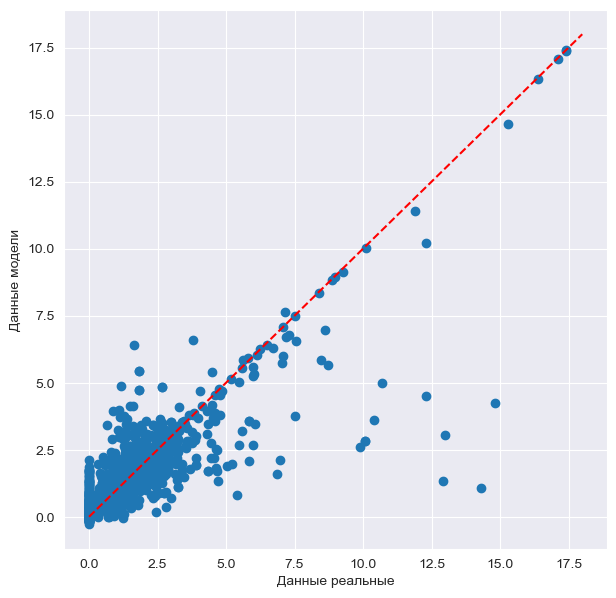

In [46]:
src.lib.model_score(model, X_test, y_test)

In [47]:
pred = model.predict(X_test)

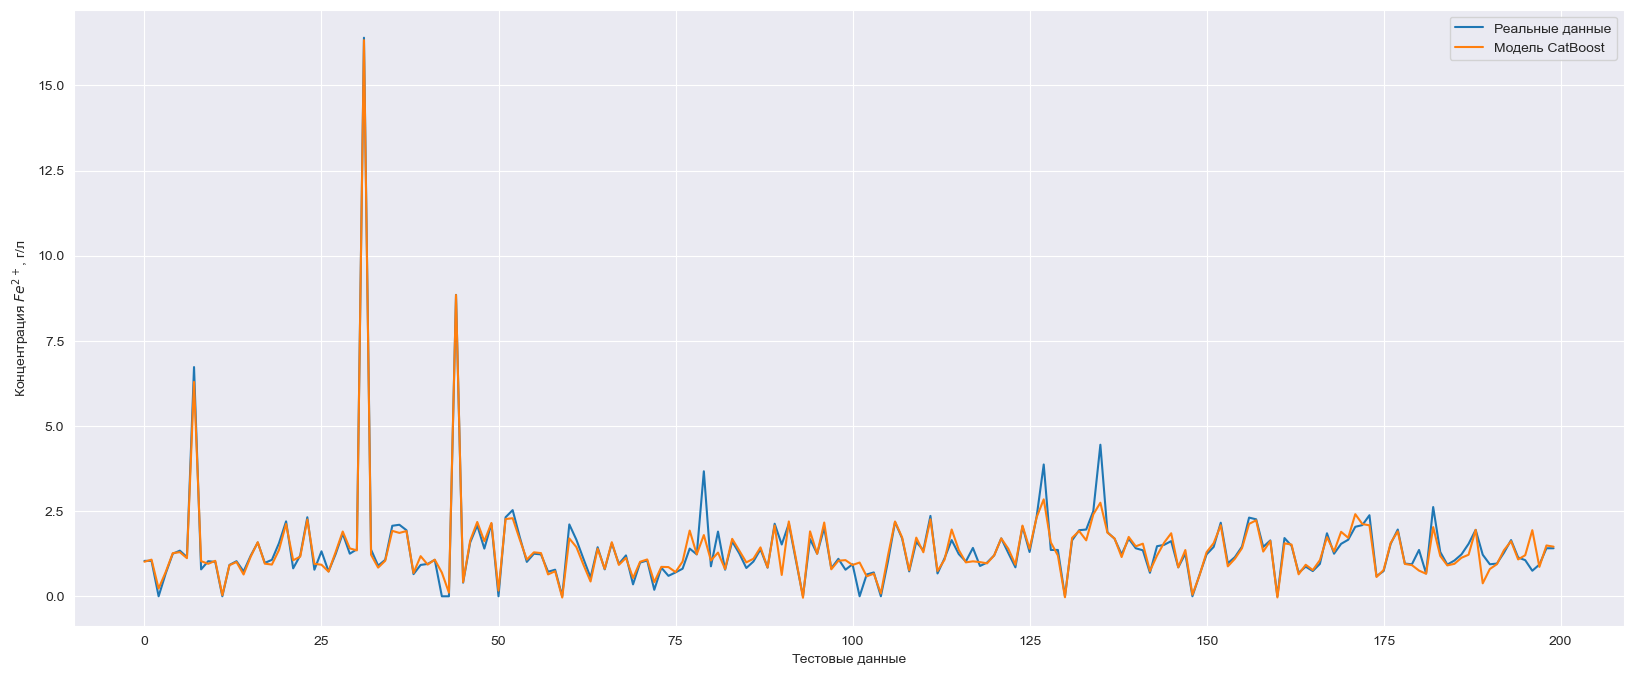

In [48]:
plt.figure(figsize=(20,8))

start = 0
end = 200

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred[start:end], label='Модель CatBoost')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

## Посмотрим наиболее важные признаки

In [26]:
# model.params["objective"] = "regression"
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

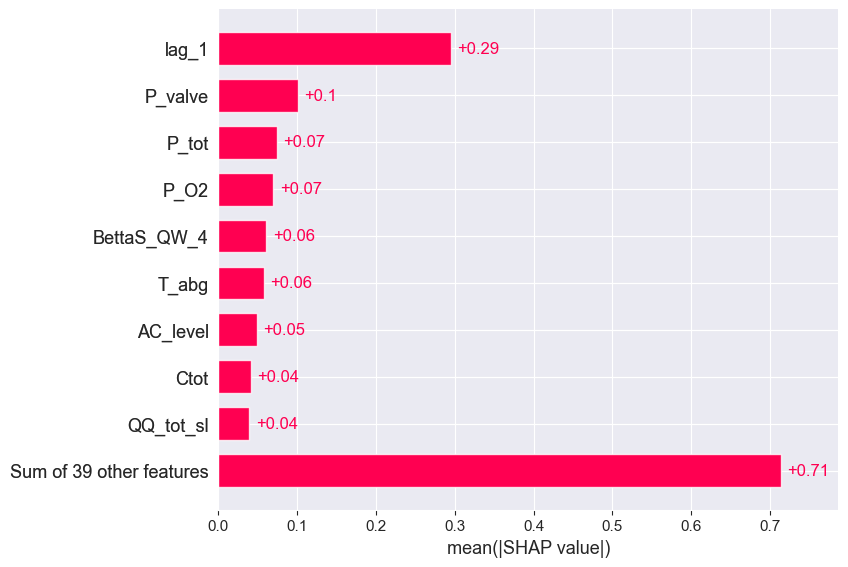

In [27]:
shap.plots.bar(shap_values)

## Сохранение модели

In [35]:
joblib.dump(model, '../models/model_lgb.pkl')

['../models/model_lgb.pkl']

Потом загрузка модели - gbm_pickle = joblib.load('lgb.pkl')